In [1]:
%cd ..

/Users/ani/Documents/time-series-forecasting


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
df_train = pd.read_csv('./data/train.csv', low_memory=False)
df_test = pd.read_csv('./data/test.csv', low_memory=False)

# Transform Date column into datetime format
df_train['ds'] = pd.to_datetime(df_train['Date'])
df_test['ds'] = pd.to_datetime(df_test['Date'])

In [4]:
df_train.rename(columns={'number_sold':'y'}, inplace=True)
df_test.rename(columns={'number_sold':'y'}, inplace=True)

In [5]:
df_train['ID'] = df_train['store'].astype('str') + '_' + df_train['product'].astype('str')

In [6]:
df = df_train.drop_duplicates(subset=['ID', 'ds'])

In [7]:
df['ds'] = df['ds'].dt.date

In [8]:
from neuralprophet import NeuralProphet

# Create model
model = NeuralProphet(
    trend_global_local = 'local',
    season_global_local= 'local',
    daily_seasonality=False,
    n_lags= 375,
    n_forecasts=365,
    epochs=20
)


/opt/anaconda3/envs/basic/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [9]:
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.date

In [10]:
df[['ID', 'ds', 'y']].dtypes

ID    object
ds    object
y      int64
dtype: object

In [11]:
# Fit model
metrics = model.fit(df[['ID', 'ds', 'y']], freq='D')

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.97% of the data.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/df_utils.

Epoch 20: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s, loss=0.0239, v_num=0, MAE=0.102, RMSE=0.137, Loss=0.0237, RegLoss=0.000]   


In [12]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,0.588261,0.832728,0.364664,0.0,0
1,0.214436,0.275387,0.085049,0.0,1
2,0.150081,0.195011,0.046362,0.0,2
3,0.130424,0.171127,0.036196,0.0,3
4,0.123395,0.162875,0.032915,0.0,4
5,0.118536,0.157205,0.030758,0.0,5
6,0.114571,0.152461,0.029018,0.0,6
7,0.111267,0.148409,0.027577,0.0,7
8,0.108563,0.145067,0.026409,0.0,8
9,0.106600,0.142612,0.025569,0.0,9


In [ ]:
df_pred = model.predict(model.make_future_dataframe(df_train[['ds', 'ID', 'y']]))

In [14]:
cols = [x for x in df_pred.columns if 'hat' in x]
df_pred['y_pred'] = df_pred[df_pred['ds'].dt.year>2018][cols].sum(axis=1)

In [15]:
df_test['ID'] = df_test['store'].astype('str') + '_' + df_test['product'].astype('str')

In [16]:
df_comb = df_pred.merge(
    df_test, 
    on=['ds', 'ID'], 
    suffixes=['_preds', '_actual'])

In [17]:
mean_absolute_percentage_error(df_comb['y_pred'], df_comb['y_actual'])

0.021110383793711662

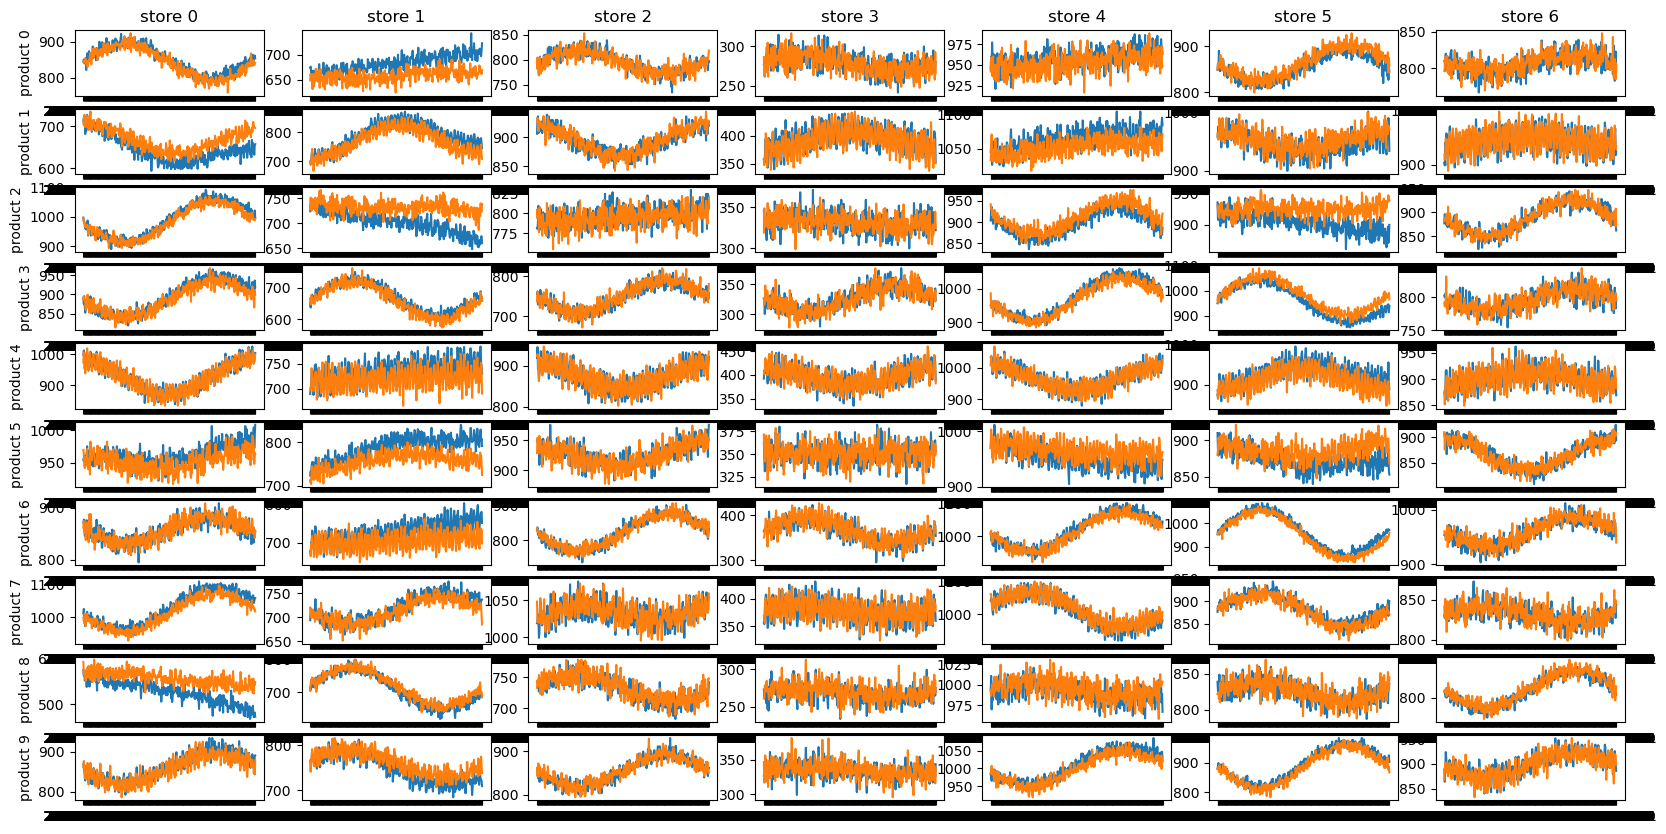

In [18]:
fig, ax = plt.subplots(10,7, figsize=(20, 10))

for s in range(7):
    for p in range(10):
        sns.lineplot(x='Date', y='y_actual', data=df_comb[df_comb['ID'] == f'{s}_{p}'], ax= ax[p, s])
        sns.lineplot(x='Date', y='y_pred', data=df_comb[df_comb['ID'] == f'{s}_{p}'], ax= ax[p, s])
        ax[p, s].set_xlabel('')
        ax[p, s].set_ylabel('')
    ax[0, s].set_title(f'store {s}')
for p in range(10):
    ax[p, 0].set_ylabel(f'product {p}')

In [19]:
model.plot_components(df_pred[(df_pred["ID"] == '0_0')].copy(deep=True))

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/basic/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:559: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [20]:
model.plot_components(df_pred[(df_pred["ID"] == '0_8')].copy(deep=True))

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


## As shown from the decomposition of the predictions, we see that the model captures different trends for different store product pairs, different yearly seasonality and also weekly sesonality.

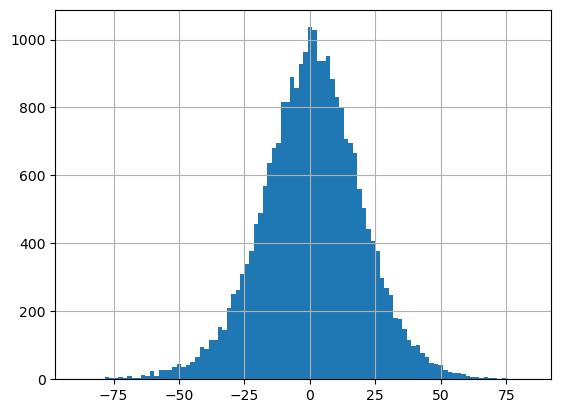

In [24]:
(df_comb['y_actual'] - df_comb['y_pred']).hist(bins=100)
plt.show()

## From the graph bove, error term of forecasts follow a normal distribution 